In [1]:
import cv2
import os
import mediapipe as mp
import scipy
from scipy.signal import find_peaks, argrelmin
import matplotlib.pyplot as plt
import tkinter as tk
import pandas as pd
import numpy as np

In [2]:
# Initialize Pose estimator
def init_estimator(path):
    mp_drawing = mp.solutions.drawing_utils
    mp_pose = mp.solutions.pose

    pose = mp_pose.Pose(
        min_detection_confidence=0.6,
        min_tracking_confidence=0.6)
    
    return mp_drawing, mp_pose, pose

In [3]:
def display_video_with_keypoints(video_path, mp_drawing, mp_pose, pose):
    """
    Display a video with detected keypoints and skeletal connections.

    Parameters:
    - video_path (str): The path to the video file.
    - mp_drawing (module): The MediaPipe drawing module for drawing landmarks.
    - mp_pose (module): The MediaPipe Pose module for pose estimation.
    - pose (MediaPipePose): The Pose instance for processing frames.

    Returns:
    None
    """

    cap = cv2.VideoCapture(video_path)

    while cap.isOpened():
        _, frame = cap.read()

        try:
            RGB = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

            results = pose.process(RGB)

            if results.pose_landmarks is not None:
                keypoints_labels = {
                    mp_pose.PoseLandmark.LEFT_ANKLE: 'LEFT ANKLE',
                    mp_pose.PoseLandmark.RIGHT_ANKLE: 'RIGHT ANKLE',
                }

                for landmark in mp_pose.PoseLandmark:
                    if landmark in keypoints_labels.keys():
                        landmark_index = landmark.value
                        landmark_name = keypoints_labels[landmark]
                        data_point = results.pose_landmarks.landmark[landmark_index]
                        x = data_point.x * frame.shape[1]  # Multiply by width to get x-coordinate in pixels
                        y = data_point.y * frame.shape[0]  # Multiply by height to get y-coordinate in pixels

                        # Draw a label near the keypoint
                        cv2.putText(frame, f"{landmark_name}", (int(x), int(y) - 10),
                                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1, cv2.LINE_AA)

            # Draw detected skeleton on the frame
            mp_drawing.draw_landmarks(
                frame, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)

            # Show the final output
            cv2.imshow('Output', frame)

        except:
            break

        if cv2.waitKey(1) == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()


In [4]:
def create_keypoint_dataframe(video_path, mp_drawing, mp_pose, pose):
    """
    Create a DataFrame with coordinates for important keypoints from a video.

    Parameters:
    - video_path (str): The path to the video file.
    - mp_drawing (module): The MediaPipe drawing module for drawing landmarks.
    - mp_pose (module): The MediaPipe Pose module for pose estimation.
    - pose (MediaPipePose): The Pose instance for processing frames.

    Returns:
    - df: A pandas DataFrame containing keypoint coordinates and additional data.
    """
    
    cap = cv2.VideoCapture(video_path)

    time = []

    right_ankle_x = []
    right_ankle_y = []

    left_ankle_x = []
    left_ankle_y = []

    right_heel_x = []
    right_heel_y = []

    left_heel_x = []
    left_heel_y = []

    right_knee_x = []
    right_knee_y = []

    left_knee_x = []
    left_knee_y = []

    right_foot_index_x = []
    right_foot_index_y = []

    left_foot_index_x = []
    left_foot_index_y = []

    right_hip_x = []
    right_hip_y = []

    left_hip_x = []
    left_hip_y = []

    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    print("Frame Width:", frame_width, "pixels\n")

    while cap.isOpened():
        # Read frame from capture object
        _, frame = cap.read()

        try:
            # Convert the frame to RGB format
            RGB = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

            # Process the RGB frame to get the result
            results = pose.process(RGB)

            if results.pose_landmarks is not None:

                keypoints_labels = {
                    mp_pose.PoseLandmark.LEFT_ANKLE,
                    mp_pose.PoseLandmark.LEFT_KNEE,
                    mp_pose.PoseLandmark.LEFT_HEEL,
                    mp_pose.PoseLandmark.LEFT_FOOT_INDEX,
                    mp_pose.PoseLandmark.LEFT_HIP,

                    mp_pose.PoseLandmark.RIGHT_ANKLE,
                    mp_pose.PoseLandmark.RIGHT_KNEE,
                    mp_pose.PoseLandmark.RIGHT_HEEL,
                    mp_pose.PoseLandmark.RIGHT_FOOT_INDEX,
                    mp_pose.PoseLandmark.RIGHT_HIP,
                }

                time.append(cap.get(cv2.CAP_PROP_POS_MSEC))

                for landmark in mp_pose.PoseLandmark:
                    if landmark in keypoints_labels:
                        landmark_index = landmark.value
                        data_point = results.pose_landmarks.landmark[landmark_index]
                        x = data_point.x * frame.shape[1]  
                        y = data_point.y * frame.shape[0]  

                        if landmark == mp_pose.PoseLandmark.RIGHT_ANKLE:
                            right_ankle_x.append(int(x))
                            right_ankle_y.append(int(y))

                        elif landmark == mp_pose.PoseLandmark.LEFT_ANKLE:
                            left_ankle_x.append(int(x))
                            left_ankle_y.append(int(y))

                        elif landmark == mp_pose.PoseLandmark.RIGHT_HEEL:
                            right_heel_x.append(int(x))
                            right_heel_y.append(int(y))

                        elif landmark == mp_pose.PoseLandmark.LEFT_HEEL:
                            left_heel_x.append(int(x))
                            left_heel_y.append(int(y))

                        elif landmark == mp_pose.PoseLandmark.RIGHT_KNEE:
                            right_knee_x.append(int(x))
                            right_knee_y.append(int(y))

                        elif landmark == mp_pose.PoseLandmark.LEFT_KNEE:
                            left_knee_x.append(int(x))
                            left_knee_y.append(int(y))

                        elif landmark == mp_pose.PoseLandmark.RIGHT_FOOT_INDEX:
                            right_foot_index_x.append(int(x))
                            right_foot_index_y.append(int(y))

                        elif landmark == mp_pose.PoseLandmark.LEFT_FOOT_INDEX:
                            left_foot_index_x.append(int(x))
                            left_foot_index_y.append(int(y))

                        elif landmark == mp_pose.PoseLandmark.RIGHT_HIP:
                            right_hip_x.append(int(x))
                            right_hip_y.append(int(y))

                        elif landmark == mp_pose.PoseLandmark.LEFT_HIP:
                            left_hip_x.append(int(x))
                            left_hip_y.append(int(y))

        except:
            break

        if cv2.waitKey(1) == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

    # Get pelvis position using the average of hip position
    pelvis_x = ((np.array(right_hip_x) + np.array(left_hip_x)) / 2).tolist()

    data = {
        'time': np.array(time) / 1000,
        'right_ankle_x': right_ankle_x,
        'right_ankle_y': right_ankle_y,
        'left_ankle_x': left_ankle_x,
        'left_ankle_y': left_ankle_y,
        'right_heel_x': right_heel_x,
        'right_heel_y': right_heel_y,
        'left_heel_x': left_heel_x,
        'left_heel_y': left_heel_y,
        'right_knee_x': right_knee_x,
        'right_knee_y': right_knee_y,
        'left_knee_x': left_knee_x,
        'left_knee_y': left_knee_y,
        'right_foot_index_x': right_foot_index_x,
        'right_foot_index_y': right_foot_index_y,
        'left_foot_index_x': left_foot_index_x,
        'left_foot_index_y': left_foot_index_y,
        'right_hip_x': right_hip_x,
        'right_hip_y': right_hip_y,
        'left_hip_x': left_hip_x,
        'left_hip_y': left_hip_y,
        'pelvis_x': pelvis_x
    }

    df = pd.DataFrame(data)
    df = df[df['time'] > 0] # Remove erroneous initial points
    
    return df, frame_width


In [5]:
def plot_keypoints(time_col, left_keypoint_col, right_keypoint_col, title, y_label):
    plt.figure(figsize=(10, 6))

    plt.scatter(time_col, left_keypoint_col, label="Left Keypoint Position", s=20)
    plt.scatter(time_col, right_keypoint_col, label="Right Keypoint Position", s=20)
#         plt.plot(dataframe['time'], dataframe[x_col], label=f'{keypoints_names[i]} x')
        
    plt.xlabel('Time (seconds)')
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

In [6]:
def swap(df, index, left_keypoint, right_keypoint, left_left, right_curr):
    """
    Swap values in a DataFrame at a specific index between left and right keypoints.

    Parameters:
    - df: The DataFrame to perform the swap on.
    - index: The index of the row to swap.
    - left_keypoint: The column name for the left keypoint.
    - right_keypoint: The column name for the right keypoint.
    - leftCurr: The value from the left keypoint to be swapped.
    - rightCurr: The value from the right keypoint to be swapped.
    """
    df.at[index, left_keypoint] = right_curr
    df.at[index, right_keypoint] = left_left

def swap_in_range(df, start, end, left_keypoint, right_keypoint):
    """
    Swap values within a specified time range in a DataFrame between left and right keypoints.

    Parameters:
    - df: The DataFrame to perform the swap on.
    - start: The start time of the range for swapping.
    - end: The end time of the range for swapping.
    - left_keypoint: The column name for the left keypoint.
    - right_keypoint: The column name for the right keypoint.
    """
    for index, row in df.iterrows():
        if start <= row['time'] <= end:
            left_curr_value = row[left_keypoint]
            right_curr_value = row[right_keypoint]
            swap(df, index, left_keypoint, right_keypoint, left_curr_value, right_curr_value)

def swap_keypoints_range(start, end):       
    swap_in_range(df, start, end, "left_ankle_x", "right_ankle_x")
    swap_in_range(df, start, end, "left_heel_x", "right_heel_x")
    swap_in_range(df, start, end, "left_foot_index_x", "right_foot_index_x")


In [7]:
def switch_left_right(df, left_keypoint, right_keypoint, threshold=25, window_size=3):
    """
    Corrects incorrectly classified left and right keypoints in a DataFrame by swapping or applying a moving average.

    Parameters:
    - df: The DataFrame containing keypoint data.
    - left_keypoint: The column name for the left keypoint.
    - right_keypoint: The column name for the right keypoint.
    - threshold: The threshold for detecting incorrect keypoints that need correction (default is 25).
    - window_size: The window size for computing the moving average (default is 3).
    """
    
    left_prev = df[left_keypoint].iloc[0]
    right_prev = df[right_keypoint].iloc[0]
    
    for index, rows in df.iterrows():
        left_curr = df[left_keypoint].iloc[index]
        right_curr = df[right_keypoint].iloc[index]
        
        left_dif = distance_between(left_curr, left_prev)
        right_dif = distance_between(right_curr, right_prev)
        
        # Swap keypoints if the distance between the current and previous keypoints exceeds the threshold
        if left_dif > threshold and right_dif > threshold:
            swap(df, index, left_keypoint, right_keypoint, left_curr, right_curr)
            
        # Recalculate current distances
        new_left = df[left_keypoint].iloc[index]
        new_right = df[right_keypoint].iloc[index]
        
        # If a keypoint exceeds the threshold after a swap, correct the keypoint with a moving average
        if distance_between(new_left, left_prev) > threshold:
            left_ma = df[left_keypoint].iloc[max(0, index - window_size + 1):index + 1].mean()
            df.at[index, left_keypoint] = left_ma
            
        if distance_between(new_right, right_prev) > threshold:
            right_ma = df[right_keypoint].iloc[max(0, index - window_size + 1):index + 1].mean()
            df.at[index, right_keypoint] = right_ma

        left_prev = df[left_keypoint].iloc[index]
        right_prev = df[right_keypoint].iloc[index]
        
def distance_between(curr, prev):
    return abs(curr - prev)
        
def swap_left_right_keypoints():
    switch_left_right(df, "left_ankle_x", "right_ankle_x")
    switch_left_right(df, "left_heel_x", "right_heel_x")
    switch_left_right(df, "left_foot_index_x", "right_foot_index_x")


In [8]:
# Calculates the horizontal distance between the ankles and pelvis
def calc_distance_ankle_pelvis(df, ankle_pos_col):
    """
    Calculate the horizontal distance between the specified ankle and pelvis keypoints in a DataFrame.

    Parameters:
    - df: The DataFrame containing keypoint data.
    - ankle: The column name for the ankle landmark (e.g., 'left_ankle_x' or 'right_ankle_x').

    Returns:
    - ankle_pelvis_distance: A pandas Series representing the horizontal distance between ankle and pelvis at each time point.
    """
    
    pelvis_x = df['pelvis_x']
    ankle_pelvis_distance = ankle_pos_col - pelvis_x
    return ankle_pelvis_distance

def graph_ankle_pelvis_distance(time_col, left_ankle_pelvis_col, right_ankle_pelvis_col):
    plt.plot(time_col, left_ankle_pelvis_col, linestyle='-', label='Left ankle and pelvis distance', color='blue')
    plt.plot(time_col, right_ankle_pelvis_col, linestyle='-', label='Right ankle and pelvis distance', color='green')
    
    plt.xlabel('Time (seconds)')
    plt.ylabel('Ankle-Pelvis Horizontal Distance (Pixels)')
    plt.title('Ankle-Pelvis Horizontal Distance Time Series (Pixels)')
    plt.legend()
    plt.grid(True)
    plt.show()


In [9]:
def find_maxima(time_col, ankle_distance_col, window_size):
    """
    Find local maxima in a curve.

    Parameters:
    - time_col: A pandas Series containing time values.
    - ankle_distance_col: A pandas Series representing the distance between ankles.
    - window_size: The width parameter for peak detection.

    Returns:
    - maxima: A NumPy array containing (time, value) pairs for the maxima.
    """
    max_peaks, _ = find_peaks(ankle_distance_col.values, width=window_size)
    max_times = time_col.iloc[max_peaks].values
    max_vals = ankle_distance_col.iloc[max_peaks].values
    maxima = np.column_stack((max_times, max_vals))
    return maxima

def find_minima(time_col, ankle_distance_col, window_size):
    """
    Find local minima in a curve.

    Parameters:
    - time_col: A pandas Series containing time values.
    - ankle_distance_col: A pandas Series representing the distance between ankles.
    - window_size: The width parameter for peak detection.

    Returns:
    - minima: A NumPy array containing (time, value) pairs for the minima.
    """
    min_peaks, _ = find_peaks(-ankle_distance_col.values, width=window_size)
    min_times = time_col.iloc[min_peaks].values
    min_vals = ankle_distance_col.iloc[min_peaks].values
    minima = np.column_stack((min_times, min_vals))
    return minima

def graph_extrema(times, curve, left_heel_strikes, right_heel_strikes):
    plt.figure(figsize=(10, 6))

    plt.plot(times, curve, color='b')

    # Plot the maxima and minima on the original curve
    plt.plot(left_heel_strikes[:, 0], left_heel_strikes[:, 1], 'ro', label='Maxima', markersize=5)
    plt.plot(right_heel_strikes[:, 0], right_heel_strikes[:, 1], 'go', label='Minima', markersize=5)

    plt.xlabel('Time (Seconds)')
    plt.ylabel('Vertical Distance between Ankles (Pixels)')
    plt.title('Vertical Distance Between Ankles over Time')
    plt.legend()
    plt.grid(True)

    plt.show()


In [10]:
def calc_midpoints(arr_1, arr_2):
    """
    Calculate the time of midpoints between two arrays of events (e.g., toe-offs and heel strikes).

    Parameters:
    - arr_1: A NumPy array containing event times (e.g., toe-off times).
    - arr_2: A NumPy array containing event times (e.g., heel strike times).

    Returns:
    - np_time_dif: A NumPy array containing the time differences between corresponding events.
    """
    
    index_1 = 0
    index_2 = 0
    time_dif = []
    
    while index_1 < arr_1.shape[0] and index_2 < arr_2.shape[0]:
        time_1 = arr_1[index_1, 0]
        time_2 = arr_2[index_2, 0]

        index_2 += 1
        if time_1 <= time_2:
            time_dif.append(time_2 - time_1)
            index_1 += 1
            
#         print(str(time_1) + " " + str(time_2))
    
    np_time_dif = np.array(time_dif)

In [11]:
def calc_angle_between(df, keypoint_1, keypoint_2, keypoint_3):
    """
    Calculate the angle in degrees between three keypoints at each time point in a DataFrame.

    Parameters:
    - df: The DataFrame containing keypoint data.
    - keypoint_1: The name of the starting keypoint (e.g. 'right_hip').
    - keypoint_2: The name of the middle keypoint (e.g. 'knee').
    - keypoint_3: The name of the ending keypoint (e.g. 'right_ankle').

    Returns:
    - angles: A list containing the calculated angles in degrees for each time point.
    """
    
    angles = []
    for index, row in df.iterrows():
        
        # X Y coordinates for each keypoint
        coordinates = {
            keypoint_1: np.array([row[keypoint_1 + '_x'], row[keypoint_1 + '_y']]),
            keypoint_2: np.array([row[keypoint_2 + '_x'], row[keypoint_2 + '_y']]),
            keypoint_3: np.array([row[keypoint_3 + '_x'], row[keypoint_3 + '_y']])
        }
        
        vector1 = coordinates[keypoint_1] - coordinates[keypoint_2]
        vector2 = coordinates[keypoint_3] - coordinates[keypoint_2]
        
        dot_product = np.dot(vector1, vector2)
        magnitude1 = np.linalg.norm(vector1)
        magnitude2 = np.linalg.norm(vector2)
        
        cos_angle = dot_product / (magnitude1 * magnitude2)
        
        angle_radians = np.arccos(cos_angle)
        angle_degrees = np.degrees(angle_radians)
        
        angles.append(angle_degrees)
        
    return angles

def add_keypoint_angles(df):
    df['right_knee_angles'] = calc_angle_between(df, 'right_hip', 'right_knee', 'right_ankle')
    df['left_knee_angles'] = calc_angle_between(df, 'left_hip', 'left_knee', 'left_ankle')

    df['right_ankle_angles'] = calc_angle_between(df, 'right_knee', 'right_ankle', 'right_foot_index')
    df['left_ankle_angles'] = calc_angle_between(df, 'left_knee', 'left_ankle', 'left_foot_index')

In [12]:
def graphKneeAngles(df):
    plt.plot(df['time'], df['right_knee_angles'], label='Right Knee Angle')
    plt.plot(df['time'], df['left_knee_angles'], label='Left Knee Angle')

    plt.xlabel('Time (seconds)')
    plt.ylabel('Angle (degrees)')
    plt.title('Knee Angle over Time')
    plt.legend()
    plt.grid()
    plt.show()

def graphAnkleAngles(df):
    plt.plot(df['time'], df['right_ankle_angles'], label='Right Ankle Angle')
    plt.plot(df['time'], df['left_ankle_angles'], label='Left Ankle Angle')

    plt.xlabel('Time (seconds)')
    plt.ylabel('Angle (degrees)')
    plt.title('Ankle Angle over Time')
    plt.legend()
    plt.grid()
    plt.show()

In [13]:
# Find knee and ankle angles at heel-strikes and toe-offs
def get_angles_at_event(df, event_arr, event):
    angles = []
    for i in range(0, len(event_arr)):
        time = event_arr[i, 0]
        angle = df[df['time'] == time][event].values[0]
        angles.append(angle)
#     print(angles)
    return angles

In [14]:
def get_angle_keypoints():

    # Angles at left heel-strikes
    right_knee_angles_left_heel = get_angles_at_event(df_angles, left_heel_strike, 'right_knee_angles')
    left_knee_angles_left_heel = get_angles_at_event(df_angles, left_heel_strike, 'left_knee_angles')
    right_ankle_angles_left_heel = get_angles_at_event(df_angles, left_heel_strike, 'right_ankle_angles')
    left_ankle_angles_left_heel = get_angles_at_event(df_angles, left_heel_strike, 'left_ankle_angles')

    # Angles at right heel-strikes
    right_knee_angles_left_heel = get_angles_at_event(df_angles, right_heel_strike, 'right_knee_angles')
    left_knee_angles_left_heel = get_angles_at_event(df_angles, right_heel_strike, 'left_knee_angles')
    right_ankle_angles_left_heel = get_angles_at_event(df_angles, right_heel_strike, 'right_ankle_angles')
    left_ankle_angles_left_heel = get_angles_at_event(df_angles, right_heel_strike, 'left_ankle_angles')

    # Angles at left toe-offs
    right_knee_angles_left_heel = get_angles_at_event(df_angles, left_toe_off, 'right_knee_angles')
    left_knee_angles_left_heel = get_angles_at_event(df_angles, left_toe_off, 'left_knee_angles')
    right_ankle_angles_left_heel = get_angles_at_event(df_angles, left_toe_off, 'right_ankle_angles')
    left_ankle_angles_left_heel = get_angles_at_event(df_angles, left_toe_off, 'left_ankle_angles')

    # Angles at right toe-offs
    right_knee_angles_left_heel = get_angles_at_event(df_angles, right_toe_off, 'right_knee_angles')
    left_knee_angles_left_heel = get_angles_at_event(df_angles, right_toe_off, 'left_knee_angles')
    right_ankle_angles_left_heel = get_angles_at_event(df_angles, right_toe_off, 'right_ankle_angles')
    left_ankle_angles_left_heel = get_angles_at_event(df_angles, right_toe_off, 'left_ankle_angles')

In [15]:
def calc_step_time(arr):
    """
    Calculate the time intervals between consecutive events in an array of event times.

    Parameters:
    - arr: A NumPy array containing event times.

    Returns:
    - mean: The mean time interval between consecutive events.
    - std: The standard deviation of the time intervals between consecutive events.
    """
    
    time_dif = []
    
    for i in range(0, len(arr) - 1):
        dif = arr[i + 1, 0] - arr[i, 0]
        time_dif.append(dif)
        
    np_time_dif = np.array(time_dif)
    mean = np.mean(np_time_dif)
    std = np.std(np_time_dif)
    
#     print(time_dif)
    
    return mean, std

In [16]:
def calc_time_between(arr_1, arr_2):
    """
    Calculate the time intervals between corresponding points in two arrays of event times.

    Parameters:
    - arr_1: A NumPy array containing initial event times.
    - arr_2: A NumPy array containing final event times.

    Returns:
    - mean: The mean time interval between corresponding points in arr_1 and arr_2.
    - std: The standard deviation of the time intervals between corresponding points in arr_1 and arr_2.
    """
    
    index_1 = 0
    index_2 = 0
    time_dif = []
    
    while index_1 < arr_1.shape[0] and index_2 < arr_2.shape[0]:
        time_1 = arr_1[index_1, 0]
        time_2 = arr_2[index_2, 0]

        index_2 += 1
        if time_1 <= time_2:
            time_dif.append(time_2 - time_1)
            index_1 += 1
            
#         print(str(time_1) + " " + str(time_2))
    
    np_time_dif = np.array(time_dif)
    mean = np.mean(np_time_dif)
    std = np.std(np_time_dif)
    
    return mean, std


In [17]:
def calc_step_length(toe_arr, heel_arr, frame_width, walkway_length):
    """
    Calculate the step length using toe and heel positions.

    Parameters:
    - toe_arr: A NumPy array containing toe positions and times.
    - heel_arr: A NumPy array containing heel positions and times.
    - frame_width: The width of the video frame in pixels.
    - walkway_length: The actual length of the walkway in meters.

    Returns:
    - mean: The mean step length in meters.
    - std: The standard deviation of step lengths in meters.
    """
    
    toe_index = 0
    heel_index = 0
    step_length = []
    
    while heel_index < heel_arr.shape[0] and toe_index < toe_arr.shape[0]:
        heel_time, heel_position = heel_arr[heel_index]
        toe_time, toe_position = toe_arr[toe_index]

        heel_index += 1
        if toe_time <= heel_time:
            step_length.append(heel_position - toe_position)
            toe_index += 1
            
            print(str(toe_position) + " " + str(heel_position))
    
    meters_per_pixel = walkway_length / frame_width
    
    step_length = np.array(step_length) * meters_per_pixel
    print(step_length)
    mean = np.mean(step_length)
    std = np.std(step_length)
    return mean, std

In [18]:
def get_features(left_heel_strike, right_heel_strike, left_toe_off, right_toe_off, frame_width):
    """
    Calculate various gait features based on heel strikes and toe offs.

    Parameters:
    - left_heel_strike: A NumPy array containing left heel strike times and positions.
    - right_heel_strike: A NumPy array containing right heel strike times and positions.
    - left_toe_off: A NumPy array containing left toe off times and positions.
    - right_toe_off: A NumPy array containing right toe off times and positions.
    - frame_width: The width of the video frame in pixels.

    Returns:
    - df_spatial_features: A pandas DataFrame containing computed gait features.
    """
    
    # Step Time: duration in seconds between consecutive bilateral heel-strikes.
    left_step_mean, left_step_std = calc_step_time(left_heel_strike)
    right_step_mean, right_step_std = calc_step_time(right_heel_strike)

    # Stance time: duration in seconds between heel-strike and toe-off of the same leg
    left_stance_mean, left_stance_std = calc_time_between(left_heel_strike, left_toe_off)
    right_stance_mean, right_stance_std = calc_time_between(right_heel_strike, right_toe_off)

    # Swing time: duration in seconds between toe-off and heel-strike of the same leg
    left_swing_mean, left_swing_std = calc_time_between(left_toe_off, left_heel_strike)
    right_swing_mean, right_swing_std = calc_time_between(right_toe_off, right_heel_strike)

    # Double support time: duration in seconds between heel-strike of one leg and toe-off of the contralateral leg.
    left_dst_mean, left_dst_std = calc_time_between(left_heel_strike, right_toe_off)
    right_dst_mean, right_dst_std = calc_time_between(right_heel_strike, left_toe_off)
    dst_mean = (left_dst_mean, right_dst_mean)
    dst_std = np.sqrt((left_dst_std**2 + right_dst_std**2) / 2)

    # Step length: anterior-posterior distance in meters between ankle keypoints at heel-strike.
    walkway_length = 6.3;
    left_step_length_mean, left_step_length_std = calc_step_length(left_toe_off, left_heel_strike, frame_width, walkway_length)
    right_step_length_mean, right_step_length_std = calc_step_length(right_toe_off, right_heel_strike, frame_width, walkway_length)

    # Gait speed: step length divided by step time.
    left_gait_speed_mean = left_step_length_mean / left_step_mean
    right_gait_speed_mean = right_step_length_mean / right_step_mean

    features = {
        'left_step_mean': left_step_mean,
        'left_step_std': left_step_std,
        'right_step_mean': right_step_mean,
        'right_step_std': right_step_std,

        'left_stance_mean': left_stance_mean,
        'left_stance_std': left_stance_std,
        'right_stance_mean': right_stance_mean,
        'right_stance_std': right_stance_std,

        'left_swing_mean': left_swing_mean,
        'left_swing_std': left_swing_std,
        'right_swing_mean': right_swing_mean,
        'right_swing_std': right_swing_std,

        'dst_mean': dst_mean,
        'dst_std': dst_std,

        'left_step_length_mean': left_step_length_mean,
        'left_step_length_std': left_step_length_std,
        'right_step_length_mean': right_step_length_mean,
        'right_step_length_std': right_step_length_std,

        'left_gait_speed_mean': left_gait_speed_mean,
        'right_gait_speed_mean': right_gait_speed_mean
    }

    df_spatial_features = pd.DataFrame(features).drop(1)
    return df_spatial_features


Frame Width: 960 pixels



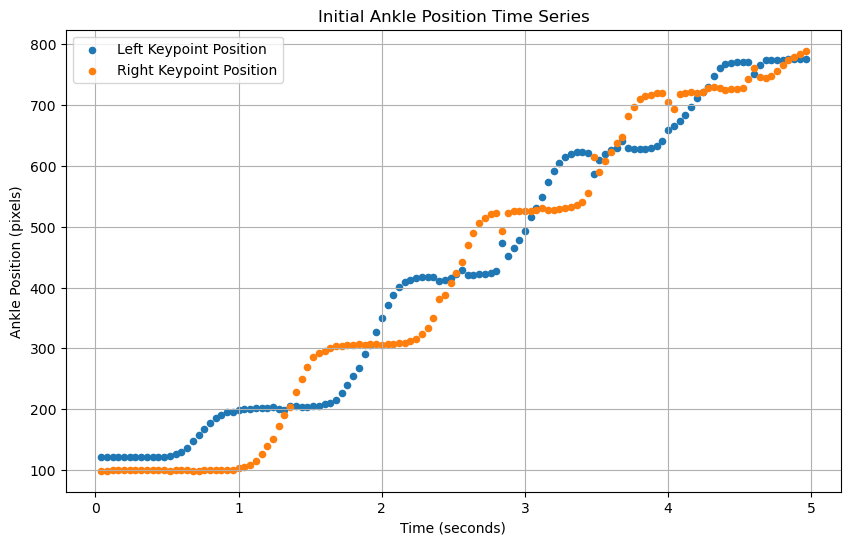

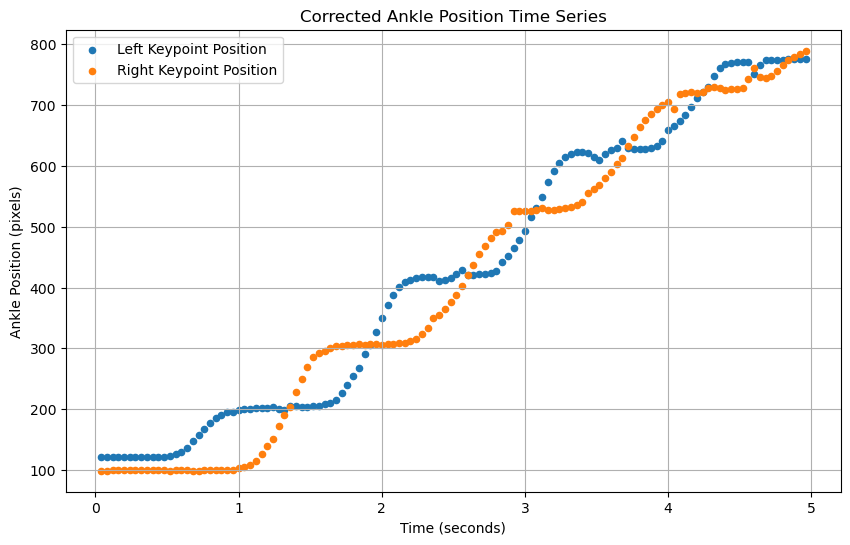

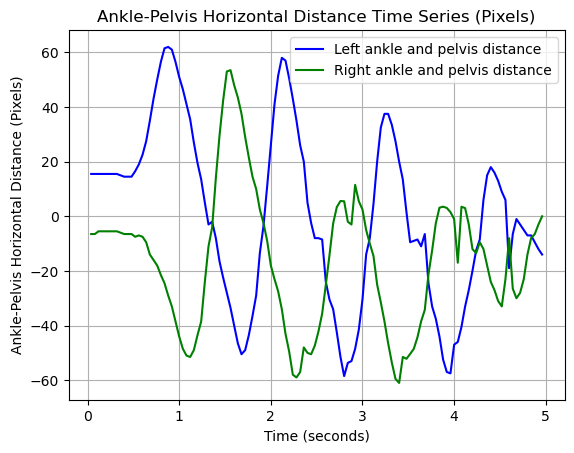

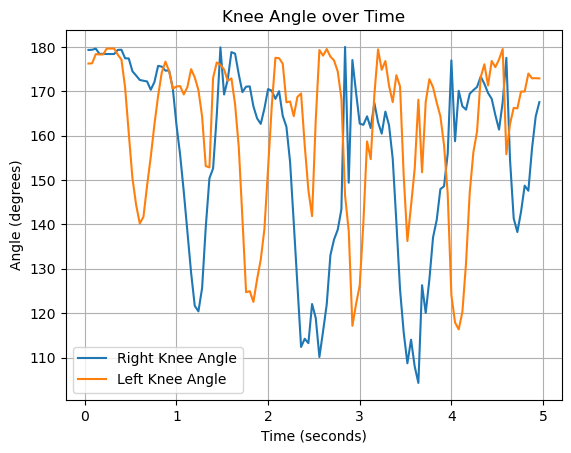

-50.5 58.0
-58.5 37.5
-57.5 18.0
[0.71203125 0.63       0.49546875]
-51.5 53.5
-59.0 11.5
-61.0 3.523579287258599
[0.6890625  0.46265625 0.42343599]
Frame Width: 960 pixels



In [ ]:
video_folder = "sagittal_videos"

# List all files in the folder
file_list = os.listdir(video_folder)

# Filter video files
video_files = [filename for filename in file_list if filename.endswith(('.avi', '.mp4'))]

df_features = pd.DataFrame()

for video_filename in video_files:
    video_path = os.path.join(video_folder, video_filename)
    mp_drawing, mp_pose, pose = init_estimator(video_path)
    
    # Video display
    # display_video(video_path, mp_drawing, mp_pose, pose)
    
    # Create dataframe of keypoint positions
    df, frame_width = create_keypoint_dataframe(video_path, mp_drawing, mp_pose, pose)
    df.head()
    time_col = df['time']
    
    # Graph initial keypoint positions
    plot_keypoints(time_col, df['left_ankle_x'], df['right_ankle_x'], "Initial Ankle Position Time Series", "Ankle Position (pixels)")
    
    # Swap incorrectly labeled left right keypoints
    swap_left_right_keypoints()
    plot_keypoints(time_col, df['left_ankle_x'], df['right_ankle_x'], "Corrected Ankle Position Time Series", "Ankle Position (pixels)")
    
    # Add columns for the distance between ankles and the pelvis
    df['right_ankle_pelvis_x'] = calc_distance_ankle_pelvis(df, df['right_ankle_x'])
    df['left_ankle_pelvis_x'] = calc_distance_ankle_pelvis(df, df['left_ankle_x'])
    
    right_ankle_pelvis_col = df['right_ankle_pelvis_x']
    left_ankle_pelvis_col = df['left_ankle_pelvis_x']
    
    graph_ankle_pelvis_distance(time_col, left_ankle_pelvis_col, right_ankle_pelvis_col)
    
    # Get times and positions of heel strikes and toe-offs
    window_size = 5
    left_heel_strike = find_maxima(time_col, left_ankle_pelvis_col, window_size)
    right_heel_strike = find_maxima(time_col, right_ankle_pelvis_col, window_size)
    left_toe_off = find_minima(time_col, left_ankle_pelvis_col, window_size)
    right_toe_off = find_minima(time_col, right_ankle_pelvis_col, window_size)
    
    # Calculate ankle and knee angles over time
    add_keypoint_angles(df)
    graphKneeAngles(df)
    
    # Calculate features for the current video
    features = get_features(left_heel_strike, right_heel_strike, left_toe_off, right_toe_off, frame_width)
    df_features = pd.concat([df_features, features], ignore_index=True)

df_features.head()
    